# Data Processing

## Introduction

This notebook is used to explore some processing techniques for the data. We will go throught dropping dupplicates, filling missing values, trying to balance the data throught differents techniques. We will also do some features selection to see which one we will keep thought different selection techniques.

## Metrics

To evaluate the models we have different choices of metrics. The one proposed in the test.py file was recall. This metric is good to evaluate the model when we want to minimize the number of false negative, which mean we don't want to miss any plaiyer that would have stayed in the NBA for 5 years or more. This metric is good, but, alone, it would mean that if the model always returns 1, then the recall will be 1 (maximum),  which makes no real sens on the model. We also want the model to differenciate between the two classes. We will then use the F1 score which is a combination of the precision and the recall. The precision is the number of true positive divided by the number of true positive and false positive. The recall is the number of true positive divided by the number of true positive and false negative. The F1 score is then the harmonic mean of the precision and the recall. The F1 score is then a good metric to evaluate the model because it takes into account the precision and the recall. After the f1 score we could watch at the recall and readjust the model so it can go a little bit more towards a good recall losing a bit of precision. It really depends on the final goal. How much is the team that buys the players able to take a paie for players that would not be able to stay in the NBA for 5 years or more. If the team is able to take a paie for players that would not stay in the NBA for 5 years or more, then we can try to maximize the recall. If the team is not able to take a paie for players that would not stay in the NBA for 5 years or more, then we can try to maximize the precision. It's really a tradeoff between the two metrics. \
Hence, we will admit that the team posseses a good amount of money. So we will use the F1 score to evaluate the model and then we will look at the recall to see if we can improve the model.

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_column', None)

data_path = './../data/nba_logreg.csv'
df = pd.read_csv(data_path)

FOLDS=3

## Preprocessing function

Let's write a function that will do all the preprocessing steps. As we discussed in the previous notebook, we talked about dropping dupplicated lines, filling missing values, balancing the data. We will try some balancing techniques to see if we can improve the model. However the majority class is the 1 and because we are tracking and recall (and f1) balancing the data might have an impact on the results not only because the model was better train, but because as we will evaluate the model with cross validation on the training set, the recall might be lower because the data is balanced. Same for precision so will be the f1 score. The global mertcis are different that metrics by class. We will still by implementing differents techniques.

In [182]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

def preprocessing(data, method=None, log=False):
    data = data.drop(['Name'], axis=1)
    data.loc[:, '3P%'] = data.loc[:, '3P%'].fillna(0)
    data = data.drop_duplicates()
    
    if method == 'oversample':
        ros = RandomOverSampler(random_state=50)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = ros.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=50)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = rus.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    elif method == 'smote':
        sm = SMOTE(random_state=50)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = sm.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)

    if log:
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X = np.log1p(X)
        data = pd.concat([X, y], axis=1)
    
    return data

In [4]:
data_preprocessed = preprocessing(df, method='smote')
data_preprocessed

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,27.400000,7.400000,2.600000,7.600000,34.700000,0.5,2.100000,25.000000,1.600000,2.300000,69.900000,0.700000,3.400000,4.100000,1.900000,0.400000,0.400000,1.300000,0.0
1,35,26.900000,7.200000,2.000000,6.700000,29.600000,0.7,2.800000,23.500000,2.600000,3.400000,76.500000,0.500000,2.000000,2.400000,3.700000,1.100000,0.500000,1.600000,0.0
2,74,15.300000,5.200000,2.000000,4.700000,42.200000,0.4,1.700000,24.400000,0.900000,1.300000,67.000000,0.500000,1.700000,2.200000,1.000000,0.500000,0.300000,1.000000,0.0
3,58,11.600000,5.700000,2.300000,5.500000,42.600000,0.1,0.500000,22.600000,0.900000,1.300000,68.900000,1.000000,0.900000,1.900000,0.800000,0.600000,0.100000,1.000000,1.0
4,48,11.500000,4.500000,1.600000,3.000000,52.400000,0.0,0.100000,0.000000,1.300000,1.900000,67.400000,1.000000,1.500000,2.500000,0.300000,0.300000,0.400000,0.800000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,43,17.022340,3.930091,1.500000,3.930091,38.349544,0.0,0.082523,0.000000,0.947568,1.247568,72.214438,0.352432,1.282523,1.634954,2.830091,0.569909,0.217477,1.565046,0.0
1644,74,20.360644,6.633481,2.577827,5.489135,46.820846,0.0,0.122173,0.000000,1.516740,1.955654,79.210423,0.850221,1.777827,2.628048,2.310423,0.866519,0.177827,1.522173,0.0
1645,47,16.909071,5.223929,2.009571,4.438286,44.532499,0.3,0.990429,27.358429,0.909571,1.314357,71.956428,0.971286,2.537786,3.509071,0.767000,0.509571,0.476071,0.828714,0.0
1646,42,7.910078,2.039994,0.900000,2.139994,41.950043,0.0,0.000000,0.000000,0.269997,0.509991,51.399942,0.720012,1.100029,1.850043,0.569997,0.200000,0.160006,0.400000,0.0


## Model evaluation

Let's create a function, based on the one provided in the `test.py` file that will evaluate the model with cross validation with 3 folds. It's important to keep the same number of folds through all the notebook to be able to compare the results. We will print a banch of differents metrics f1, precsion, recall, accuracy and the confusion matrix. As we do the evaluation and train on many folds we will take the mean of each metrics on all tests sets evaluated.

In [161]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import KFold

def score_classifier(dataset,classifier,labels, folds=FOLDS, verbose=True):
    
    """
    This function takes in a dataset, classifier and labels and returns the mean confusion matrix, recall, precision, accuracy and f1 score
    for the classifier using KFold cross validation with the number of folds specified by the user

    Parameters:
    dataset: pandas dataframe
    classifier: sklearn classifier
    labels: pandas series
    folds: int

    Returns:
    dict: dictionary containing mean confusion matrix, recall, precision, accuracy and f1 score
    """

    kf = KFold(n_splits=folds,random_state=50,shuffle=True)
    confusion_mat_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    f1_list = []

    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)

        confusion_mat = confusion_matrix(test_labels,predicted_labels)
        recall = recall_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels)
        accuracy = classifier.score(test_set, test_labels)
        f1 = 2 * (precision * recall) / (precision + recall)

        recall_list.append(recall)
        precision_list.append(precision)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        confusion_mat_list.append(confusion_mat)

    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    accuracy = np.mean(accuracy_list)
    f1 = np.mean(f1_list)
    confusion_mat = np.mean(confusion_mat_list,axis=0).astype(int)
    confusion_mat_df = pd.DataFrame(confusion_mat,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

    if verbose:
        print(f"confusion_mat: \n {confusion_mat_df}")
        print(f"recall:{recall}")
        print(f"precision:{precision}")
        print(f"accuracy:{accuracy}")
        print(f"f1:{f1}")
    return {'confusion_mat':confusion_mat,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1, 'classifier':classifier}


Let's have a first look at the scores on a simple logistic regression model.

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


target = 'TARGET_5Yrs'
balancer_method = None

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method)

scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target])


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           89           78
Actual 1           52          222
recall:0.8074650768895374
precision:0.7388524886295587
accuracy:0.7040625244715008
f1:0.771521903655596


We note our first f1 score = 0.7715 and recall = 0.8074. Note that we had to use the another solver to make the model converge. We might try other solvers later on.

## Transform the data to log1p

As we saw in the previous notebook, the data is not normally distributed. We will then apply a log1p transformation to the data to make it more normally distributed. We will then apply the log1p transformation to all the data except the target.

In [207]:
target = 'TARGET_5Yrs'
balancer_method = None

model = LogisticRegression(C=1, solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target])

confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           83           84
Actual 1           47          227
recall:0.8272802736831514
precision:0.7282334789868296
accuracy:0.7018017833978529
f1:0.7744435394395909


We can observe a slight improvement of the f1 score and the recall. We will then keep the data transformed. Since logistci regression is a linear model, it's better to have the data normally distributed.

## Balancing the data

Let's try balancing the data. We will try basic undersampling and oversampling techniques. We will also try the SMOTE technique.

In [212]:
balancer_method = [None, 'undersample', 'oversample', 'smote']

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

scores_blance_method = []
for method in balancer_method:
    data_preprocessed = preprocessing(df, method=method, log=True)
    scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target], verbose=False)
    scores_blance_method.append(scores)

scores_blance_method = pd.DataFrame(scores_blance_method)
scores_blance_method['balancer_method'] = balancer_method
scores_blance_method.sort_values(by=['recall', 'f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,balancer_method
0,"[[83, 84], [47, 227]]",0.827280,0.728233,0.701802,0.774444,LogisticRegression(solver='liblinear'),None
1,"[[118, 49], [55, 112]]",0.669328,0.697170,0.687500,0.681182,LogisticRegression(solver='liblinear'),undersample
3,"[[195, 79], [91, 183]]",0.667654,0.697516,0.688723,0.681951,LogisticRegression(solver='liblinear'),smote
2,"[[199, 75], [92, 182]]",0.664062,0.707600,0.694177,0.684473,LogisticRegression(solver='liblinear'),oversample


As we can see, the f1 score and the recall are lower than before. Since 1 is the majority class, balancing the data is affecting the overall scores and comparing these scores with unbalanced data is a bit complicated. However as the recall is important to us having the '1' class a bit bigger might help guiding the model towards a good recall. Furthermore, the F1 score drop significatively. We will try to balance the data with weights in the model.

In [211]:
target = 'TARGET_5Yrs'
balancer_method = None

model = LogisticRegression(solver='liblinear', class_weight='balanced')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method)

scores = score_classifier(data_preprocessed.drop(target, axis=1), model, data_preprocessed[target])

confusion_mat: 
           Predicted 0  Predicted 1
Actual 0          120           48
Actual 1           92          182
recall:0.6640648320504435
precision:0.7918856298032546
accuracy:0.6837328784613342
f1:0.7221147928836501


Balancing the data with wieghts techniques didn't improve the model as well in term of f1 score and recall. We will then keep the data unbalanced. However the precision is better than before. The class '0' as been better predicted, but our focus is on the '1' class.

## Features selection

In this section we will try to select the best features to keep in the model. We will try different techniques. We will try to select the best features with a correlation matrix, with a random forest classifier and with a logistic regression model.

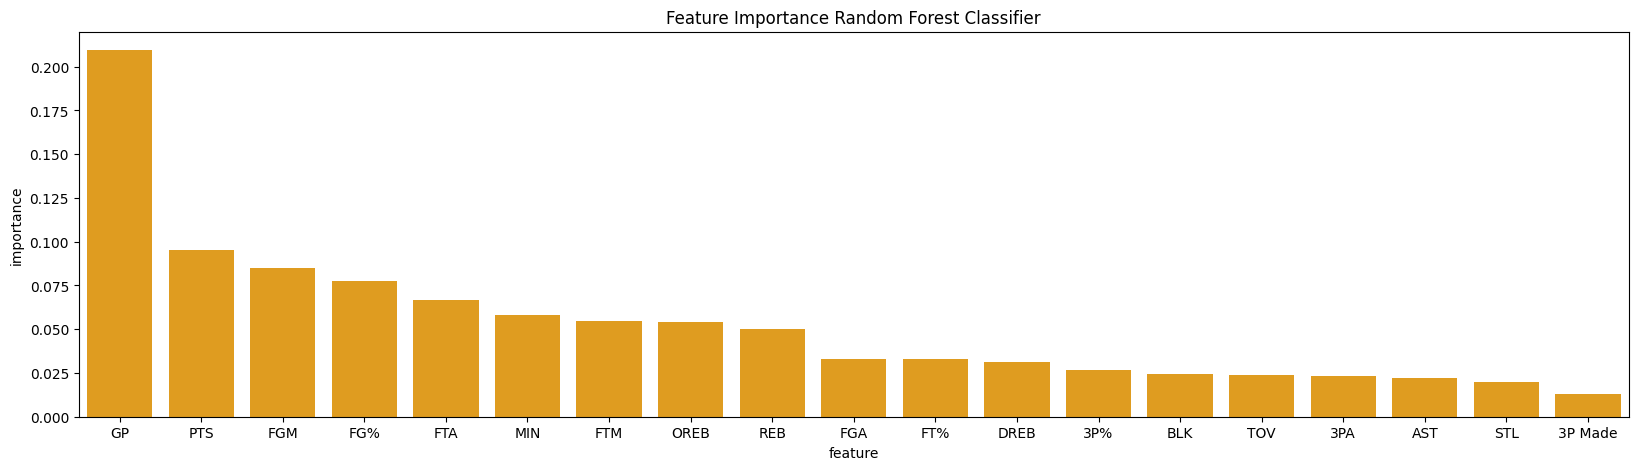

In [209]:
from sklearn.ensemble import RandomForestClassifier

target = 'TARGET_5Yrs'
balancer_method = None

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=50)
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

data_preprocessed = preprocessing(df, method=balancer_method, log=True)
pipeline.fit(data_preprocessed.drop(target, axis=1), data_preprocessed[target])

feature_importance_rf = pd.DataFrame({'feature': data_preprocessed.drop(target, axis=1).columns, 'importance': pipeline.named_steps['model'].feature_importances_})
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='importance', data=feature_importance_rf.sort_values(by='importance', ascending=False), color='orange')
plt.title('Feature Importance Random Forest Classifier')
plt.show()


With the randomforest classifier we can see that the `GP` feature (Game played) is significatively more important than the other features. The otheres features are less important regarding the the randomforest classifier. \

Let's try to see the correlation with the target variable.

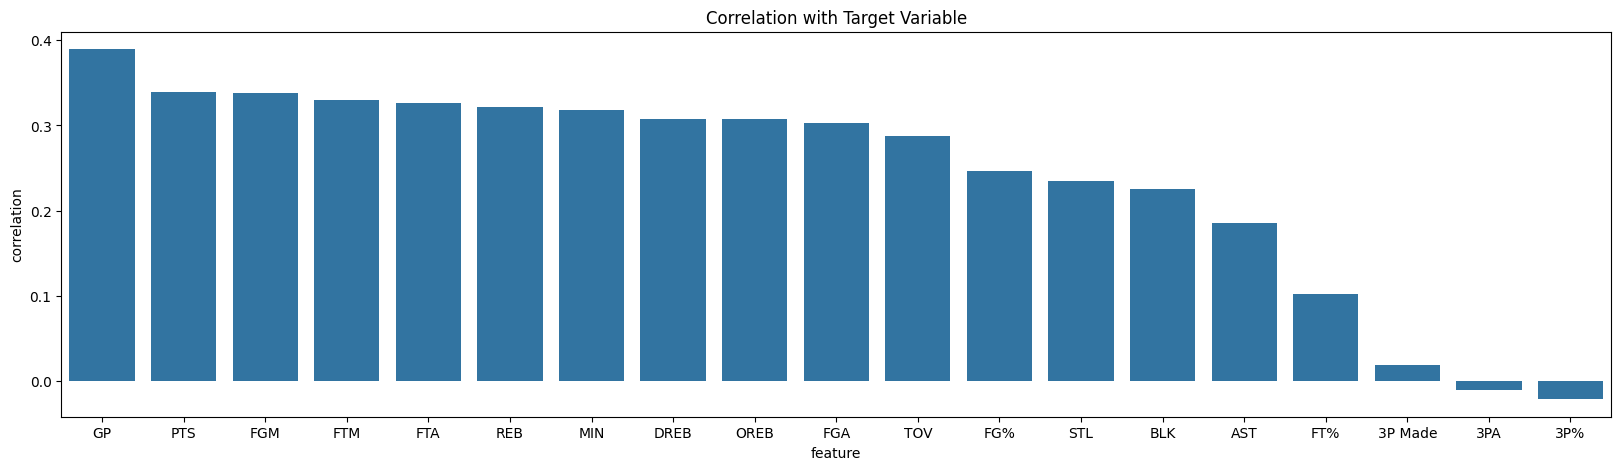

In [210]:
target = 'TARGET_5Yrs'
balancer_method = None

data_preprocessed = preprocessing(df, method=balancer_method, log=True)

correlation_matrix_target = data_preprocessed.corr()[target].sort_values(ascending=False)
correlation_matrix_target = correlation_matrix_target.drop(target)
correlation_matrix_target = pd.DataFrame({'feature': correlation_matrix_target.index, 'correlation': correlation_matrix_target.values})
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='correlation', data=correlation_matrix_target.sort_values(by='correlation', ascending=False))
plt.title('Correlation with Target Variable')
plt.show()

Using the correlation, the `GP` feature shows the highest correlation with the target variable, followed closely by `PTS`, `FGM`, `FTM`, and `FTA`. These high correlation coefficients suggest that the number of games played and the ability to score (whether through field goals or free throws) are strong indicators of a player's longevity in the NBA. \

let's see what we have with the combinedd scores of the two previous techniques.

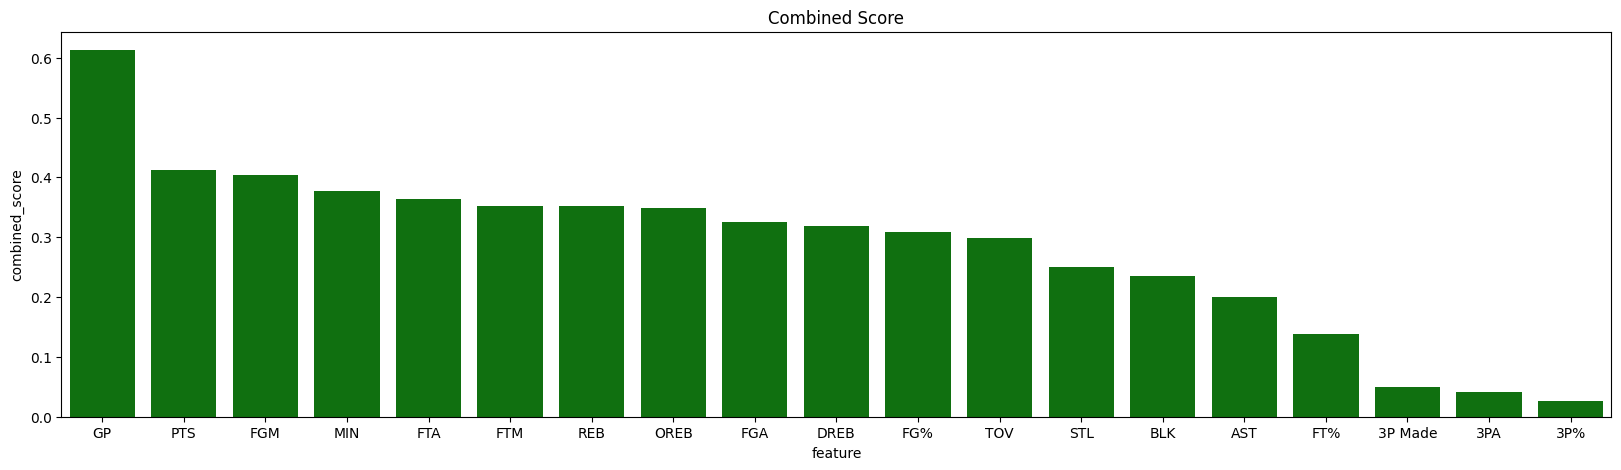

In [61]:
combined_df = correlation_matrix_target.merge(feature_importance_rf, on='feature')

combined_df['combined_score'] = combined_df['correlation'] + combined_df['importance']
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='combined_score', data=combined_df.sort_values(by='combined_score', ascending=False), color='green')
plt.title('Combined Score')
plt.show()

We observe a similar result as the random forest classifier. The `GP` feature is the most important one. The sames `3P Made`, `3PA` and `3P%` are the least important features. \
Let's compute the percentage of both methods on the same graph.

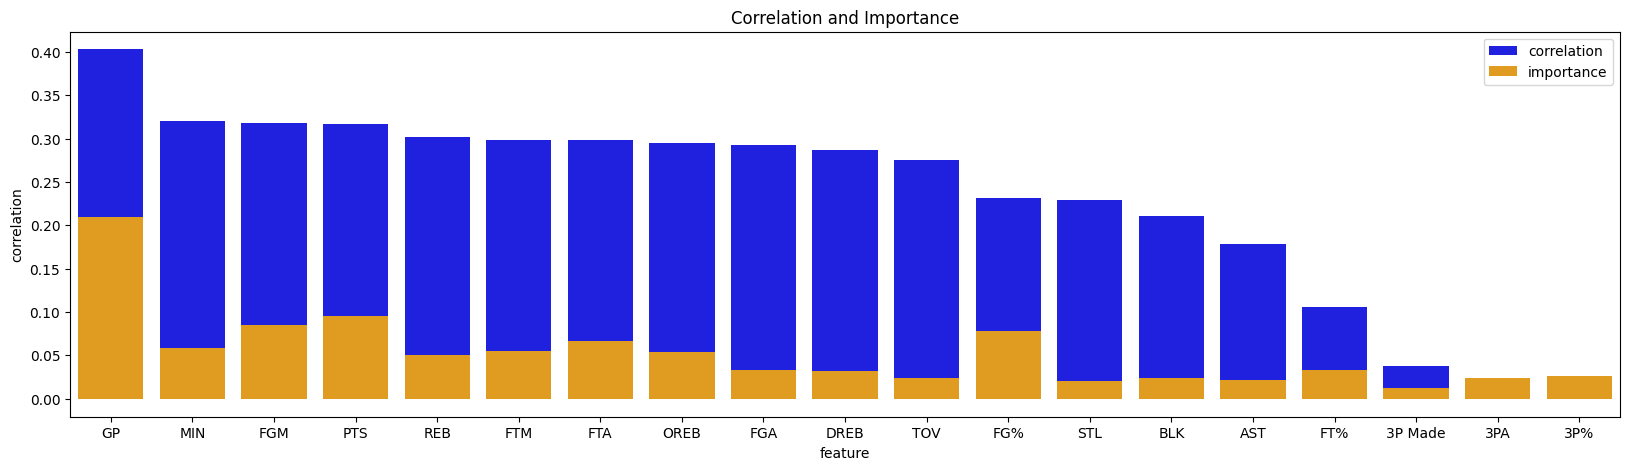

In [62]:
plt.figure(figsize=(20, 5))
sns.barplot(x='feature', y='correlation', data=correlation_matrix_target.sort_values(by='correlation', ascending=False), color='blue', label='correlation')
sns.barplot(x='feature', y='importance', data=feature_importance_rf.sort_values(by='importance', ascending=False), color='orange', label='importance')
plt.title('Correlation and Importance')
plt.show()

We will now try to see how many variables by method selection is optimal.

In [217]:
# feature selection : random forest

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores_features_number = []
for number in features_number:
    features_selected = feature_importance_rf.sort_values(by='importance', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)




,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
1,"[[66, 102], [37, 237]]",0.864612,0.699503,0.685236,0.772844,LogisticRegression(solver='liblinear'),2
2,"[[67, 100], [39, 235]]",0.857518,0.701301,0.684489,0.771022,LogisticRegression(solver='liblinear'),3
6,"[[77, 91], [42, 232]]",0.844598,0.718003,0.698029,0.775680,LogisticRegression(solver='liblinear'),7
4,"[[75, 93], [43, 231]]",0.842283,0.713141,0.692006,0.771874,LogisticRegression(solver='liblinear'),5
5,"[[77, 91], [43, 231]]",0.840918,0.717218,0.695770,0.773664,LogisticRegression(solver='liblinear'),6
9,"[[81, 86], [44, 230]]",0.839218,0.726364,0.704803,0.778638,LogisticRegression(solver='liblinear'),10
8,"[[81, 86], [44, 230]]",0.836970,0.725902,0.703300,0.777380,LogisticRegression(solver='liblinear'),9
7,"[[83, 84], [45, 229]]",0.835838,0.730194,0.707062,0.779342,LogisticRegression(solver='liblinear'),8
12,"[[82, 85], [45, 229]]",0.835688,0.727854,0.704810,0.777996,LogisticRegression(solver='liblinear'),13


In [218]:
scores_features_number.sort_values(by=['f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
7,"[[83, 84], [45, 229]]",0.835838,0.730194,0.707062,0.779342,LogisticRegression(solver='liblinear'),8
17,"[[84, 84], [45, 229]]",0.834374,0.731322,0.707820,0.779308,LogisticRegression(solver='liblinear'),18
9,"[[81, 86], [44, 230]]",0.839218,0.726364,0.704803,0.778638,LogisticRegression(solver='liblinear'),10
16,"[[84, 84], [45, 229]]",0.833175,0.731079,0.707064,0.778610,LogisticRegression(solver='liblinear'),17
12,"[[82, 85], [45, 229]]",0.835688,0.727854,0.704810,0.777996,LogisticRegression(solver='liblinear'),13
13,"[[83, 85], [45, 229]]",0.833274,0.728752,0.704806,0.777454,LogisticRegression(solver='liblinear'),14
10,"[[82, 86], [45, 229]]",0.835522,0.727045,0.704052,0.777403,LogisticRegression(solver='liblinear'),11
15,"[[83, 85], [45, 229]]",0.833191,0.728791,0.704806,0.777386,LogisticRegression(solver='liblinear'),16
8,"[[81, 86], [44, 230]]",0.836970,0.725902,0.703300,0.777380,LogisticRegression(solver='liblinear'),9


Reagrding the f1 score for random forest it's only keeping 1 feature that is the best.

In [219]:
# model search - feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP']

data_processed = preprocessing(df, balance_method, log=True)
X = data_processed[features_selected]
y = data_processed[target]

model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('model', model)])


score = score_classifier(X, pipeline, y, verbose=False)
score['model'] = 'LogisticRegression'

score


{'confusion_mat': array([[ 43, 124],
        [ 18, 256]]),
 'recall': 0.9315163254012174,
 'precision': 0.6719784615484733,
 'accuracy': 0.6761777814094904,
 'f1': 0.7806074396628451,
 'classifier': Pipeline(steps=[('model', LogisticRegression(solver='liblinear'))]),
 'model': 'LogisticRegression'}

We improved the f1 score up to 0.7806 and the recall up to 0.9315. Let's try with correlation.

In [220]:
# feature selection : correlation

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores_features_number = []
for number in features_number:
    features_selected = correlation_matrix_target.sort_values(by='correlation', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)


,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
1,"[[66, 102], [37, 237]]",0.864612,0.699503,0.685236,0.772844,LogisticRegression(solver='liblinear'),2
3,"[[72, 95], [39, 235]]",0.858067,0.712061,0.696530,0.777936,LogisticRegression(solver='liblinear'),4
4,"[[72, 95], [39, 235]]",0.857935,0.711277,0.695775,0.777384,LogisticRegression(solver='liblinear'),5
2,"[[67, 100], [39, 235]]",0.857518,0.701301,0.684489,0.771022,LogisticRegression(solver='liblinear'),3
6,"[[76, 92], [40, 234]]",0.854270,0.718170,0.701800,0.780151,LogisticRegression(solver='liblinear'),7
9,"[[77, 90], [40, 234]]",0.852339,0.721379,0.704068,0.781194,LogisticRegression(solver='liblinear'),10
10,"[[78, 90], [40, 234]]",0.852105,0.722055,0.704817,0.781535,LogisticRegression(solver='liblinear'),11
5,"[[78, 89], [41, 233]]",0.850922,0.722603,0.704817,0.781322,LogisticRegression(solver='liblinear'),6
8,"[[78, 89], [41, 233]]",0.850774,0.722475,0.704813,0.781195,LogisticRegression(solver='liblinear'),9


In [221]:
scores_features_number.sort_values(by=['f1'], ascending=False)


,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
10,"[[78, 90], [40, 234]]",0.852105,0.722055,0.704817,0.781535,LogisticRegression(solver='liblinear'),11
5,"[[78, 89], [41, 233]]",0.850922,0.722603,0.704817,0.781322,LogisticRegression(solver='liblinear'),6
8,"[[78, 89], [41, 233]]",0.850774,0.722475,0.704813,0.781195,LogisticRegression(solver='liblinear'),9
9,"[[77, 90], [40, 234]]",0.852339,0.721379,0.704068,0.781194,LogisticRegression(solver='liblinear'),10
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
6,"[[76, 92], [40, 234]]",0.854270,0.718170,0.701800,0.780151,LogisticRegression(solver='liblinear'),7
14,"[[84, 83], [45, 229]]",0.834690,0.732164,0.708575,0.779988,LogisticRegression(solver='liblinear'),15
15,"[[84, 83], [45, 229]]",0.833457,0.732726,0.708574,0.779724,LogisticRegression(solver='liblinear'),16
11,"[[81, 86], [44, 230]]",0.839301,0.726460,0.704805,0.778711,LogisticRegression(solver='liblinear'),12
16,"[[84, 83], [46, 228]]",0.831126,0.732189,0.707069,0.778368,LogisticRegression(solver='liblinear'),17


Regarding the f1 score for correlation keeping 11 features is the best.

In [223]:
# feature selection : combined score

target = 'TARGET_5Yrs'
balancer_method = None

features_number = range(1, 20)

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores_features_number = []
for number in features_number:
    features_selected = combined_df.sort_values(by='combined_score', ascending=False).head(number)['feature'].values
    scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], verbose=False)
    scores_features_number.append(scores)

scores_features_number = pd.DataFrame(scores_features_number)
scores_features_number['features_number'] = features_number
scores_features_number.sort_values(by=['recall', 'f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
1,"[[66, 102], [37, 237]]",0.864612,0.699503,0.685236,0.772844,LogisticRegression(solver='liblinear'),2
3,"[[68, 100], [37, 237]]",0.864495,0.703676,0.689749,0.775327,LogisticRegression(solver='liblinear'),4
4,"[[69, 98], [38, 236]]",0.860799,0.706114,0.691261,0.775392,LogisticRegression(solver='liblinear'),5
5,"[[71, 96], [38, 236]]",0.860716,0.710281,0.695779,0.777897,LogisticRegression(solver='liblinear'),6
2,"[[67, 100], [39, 235]]",0.857518,0.701301,0.684489,0.771022,LogisticRegression(solver='liblinear'),3
6,"[[76, 92], [40, 234]]",0.854270,0.718170,0.701800,0.780151,LogisticRegression(solver='liblinear'),7
9,"[[77, 90], [40, 234]]",0.852339,0.721379,0.704068,0.781194,LogisticRegression(solver='liblinear'),10
8,"[[77, 90], [41, 233]]",0.851140,0.720342,0.702563,0.780103,LogisticRegression(solver='liblinear'),9
7,"[[77, 90], [41, 233]]",0.850657,0.720220,0.702551,0.779825,LogisticRegression(solver='liblinear'),8


In [224]:
scores_features_number.sort_values(by=['f1'], ascending=False)

,confusion_mat,recall,precision,accuracy,f1,classifier,features_number
9,"[[77, 90], [40, 234]]",0.852339,0.721379,0.704068,0.781194,LogisticRegression(solver='liblinear'),10
0,"[[43, 124], [18, 256]]",0.931516,0.671978,0.676178,0.780607,LogisticRegression(solver='liblinear'),1
6,"[[76, 92], [40, 234]]",0.854270,0.718170,0.701800,0.780151,LogisticRegression(solver='liblinear'),7
8,"[[77, 90], [41, 233]]",0.851140,0.720342,0.702563,0.780103,LogisticRegression(solver='liblinear'),9
14,"[[84, 83], [45, 229]]",0.834690,0.732164,0.708575,0.779988,LogisticRegression(solver='liblinear'),15
7,"[[77, 90], [41, 233]]",0.850657,0.720220,0.702551,0.779825,LogisticRegression(solver='liblinear'),8
15,"[[84, 83], [45, 229]]",0.833457,0.732726,0.708574,0.779724,LogisticRegression(solver='liblinear'),16
11,"[[81, 86], [44, 230]]",0.839301,0.726460,0.704805,0.778711,LogisticRegression(solver='liblinear'),12
16,"[[84, 83], [46, 228]]",0.831126,0.732189,0.707069,0.778368,LogisticRegression(solver='liblinear'),17
5,"[[71, 96], [38, 236]]",0.860716,0.710281,0.695779,0.777897,LogisticRegression(solver='liblinear'),6


Regarding the combined score keeping 10 features is the best.

In [225]:
target = 'TARGET_5Yrs'
balancer_method = None

features_number = 10

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

features_selected = combined_df.sort_values(by='combined_score', ascending=False).head(features_number)['feature'].values
scores = score_classifier(data_preprocessed[features_selected[:number]], model, data_preprocessed[target], verbose=True)


print(f"features_selected: {features_selected}")


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           77           90
Actual 1           40          234
recall:0.8523385487414264
precision:0.7213787290838295
accuracy:0.7040676315672997
f1:0.7811936488314165
features_selected: ['GP' 'PTS' 'FGM' 'MIN' 'FTA' 'FTM' 'REB' 'OREB' 'FGA' 'DREB']


We improved the f1 score with the combined features selection up to 0.7811. We might keep the features selected with the combined features selection. \

In the last notebook, we saw that many features where correlated between each other. We will try another selection technique which keep features with a correlation bigger than 0.1 with the target and removing features that are correlated between each other with a threshold of 0.75.

In [239]:
processed_data = preprocessing(df, method=None)

correlation_matrix = processed_data.corr().abs()

high_corr_with_target = correlation_matrix[target][correlation_matrix[target] > 0.1].index.tolist()

upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]

selected_features = [feature for feature in high_corr_with_target if feature not in to_drop]

target = 'TARGET_5Yrs'
balancer_method = None


model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores = score_classifier(data_preprocessed[selected_features].drop(target, axis=1), model, data_preprocessed[target], verbose=True)
selected_features.remove(target)


print(f"features_selected: {selected_features}")


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           78           89
Actual 1           43          231
recall:0.8419479800774766
precision:0.7202726733727484
accuracy:0.6995393399589389
f1:0.7763032331003061
features_selected: ['GP', 'MIN', 'FG%', 'FT%', 'OREB', 'AST', 'BLK']


We did not improve the f1 score. We will then keep the features selected with the combined features selection. \

Let's try a selection with regularisation using Lasso.

In [240]:
from sklearn.linear_model import LassoCV

processed_data = preprocessing(df, method=None)

X = processed_data.drop(target, axis=1)
y = processed_data[target]

reg = LassoCV()
reg.fit(X, y)

coef = pd.Series(reg.coef_, index = X.columns)
selected_features = coef[coef != 0].index.tolist()

target = 'TARGET_5Yrs'
balancer_method = None

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores = score_classifier(data_preprocessed[selected_features], model, data_preprocessed[target], folds=5, verbose=True)

print(f"features_selected: {selected_features}")

confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           49           51
Actual 1           26          138
recall:0.8383669902263927
precision:0.7304191977522808
accuracy:0.7078223861540643
f1:0.7800770279703746
features_selected: ['GP', 'MIN', 'PTS', 'FGA', 'FG%', '3P%', 'FT%', 'OREB', 'DREB', 'AST', 'BLK']


The result is better than the previous one but not as good as the combined technique. We will then keep the features selected with the combined features selection.

Let's try a last selection using iteration over the most 15 important features to explore all the different combination in this feature space. The computation is about 20 minutes long so we wont add more variables. Adding a variable multiply by the the time of computation.

In [244]:
import itertools
from sklearn.model_selection import cross_val_score, KFold

NB_FEATURES = 15

features_start = combined_df.sort_values(by='combined_score', ascending=False).head(NB_FEATURES)['feature'].values

data_preprocessed = preprocessing(df, method=None, log=True)

X = data_preprocessed[features_start]
y = data_preprocessed[target]

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=FOLDS, shuffle=True, random_state=50)

scores_and_features = []

for k in range(1, len(X.columns) + 1):
    for subset in itertools.combinations(X.columns, k):
        
        X_subset = X[list(subset)]
        
        score = cross_val_score(model, X_subset, y, cv=cv, scoring='f1').mean()
        
        scores_and_features.append((score, subset))

best_score, best_features = max(scores_and_features, key=lambda sf: sf[0])

print(f"Best score: {best_score}")
print(f"Best feature combination: {best_features}")

Best score: 0.7911930559933044
Best feature combination: ('GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST')


Let's compute the score for the selected features in the brut force over the best 15 features.

In [254]:
target = 'TARGET_5Yrs'
balancer_method = None

features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

model = LogisticRegression(solver='liblinear')
steps = [('model', model)]

pipeline = Pipeline(steps=steps)
data_preprocessed = preprocessing(df, method=balancer_method, log=True)

scores = score_classifier(data_preprocessed[features_selected], model, data_preprocessed[target], folds=FOLDS, verbose=True)

print(f"features_selected: {features_selected}")


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           81           86
Actual 1           38          236
recall:0.8609473260552397
precision:0.7324455052916067
accuracy:0.7183743092652932
f1:0.7911930559933044
features_selected: ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']


Here's a summary of the selection and the rationale behind each chosen variable:

- GP (Games Played): This feature is likely considered critical as it reflects a player's durability and consistency. Players who appear in more games are generally more reliable and potentially have a greater impact on their team's success.

- PTS (Points): The ability to score points is fundamental to basketball, and players who score more points are typically more valuable to their teams. This variable is a direct measure of a player's offensive contribution.

- FTA (Free Throw Attempts) & FTM (Free Throws Made): These two features indicate not only a player's ability to get to the free-throw line, often through aggressive offensive play, but also their skill at capitalizing on these opportunities by scoring.

- FGA (Field Goal Attempts): This metric suggests a player's level of involvement in the offensive play. Frequent attempts may indicate a player's confidence and role as a scorer, although this measure doesn't account for shooting efficiency.

- DREB (Defensive Rebounds): Defensive rebounds are a crucial aspect of the defensive game, stopping the opposing team from getting second-chance points. It's a sign of a player's defensive skill and effort.

- BLK (Blocks): Blocks are a clear indicator of a defensive prowess. A player who can block shots can prevent the opponent from scoring and can change the momentum of the game.

The chosen features provide a balanced mix of metrics that capture a player's offensive output (points, field goal attempts, free throws) and defensive contributions (rebounds and blocks). The selection suggests that these features, when used together, provided the best predictive performance for the model based on the evaluation metric used, which could be accuracy, precision, recall, F1 score, or any other relevant performance metric.

This approach aims to identify players who not only contribute significantly in terms of scoring and offensive involvement but also demonstrate the ability to perform defensively, both of which are likely considered indicators of a player's potential to have a long and successful NBA career.

## Conclusion

We improved the f1 score up to 0.7842 and the recall up to 0.8608. We will then keep the features selected with the combined features selection.

However we improved the preprocessing over only one model. In th next notebook we will explore other models and tune the hyperparameters of the models to see if we can improve the f1 score and the recall. The preprocessing might have adapted too much to the logistic regression model we have to keep this in mind. 